In [1]:
import sys, os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

# uncomment the following line if you want to force CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

print("Python version is: " + sys.version)
print("Tensorflow version is: " + tf.__version__)

Python version is: 3.11.2 (main, Mar 27 2023, 23:42:44) [GCC 11.2.0]
Tensorflow version is: 2.12.0


# Defining the dataset

In [2]:
import random

dataset_path = "custom_face_database"

files = [os.path.join(r,file) for r,d,f in os.walk(dataset_path) for file in f]

file_size = len(files)

print("We have " + str(file_size) + " images.")

random.shuffle(files)

We have 360 images.


## generating classes and labels

Let's define the label for each class

In [3]:
import numpy as np

def make_instances(files, classes = []):
    labels = []
    for i in range(len(files)):
        file = files[i]
        clazz = file.split("/")[-2]
        
        if classes.count(clazz):
            label = classes.index(clazz)
        else:
            label = len(classes)
            classes.append(clazz)

        labels.append(label)

    return np.array(labels), np.array(classes)

labels, classes = make_instances(files)
CLASSES_SIZE = len(classes)

print(str(CLASSES_SIZE) + " classes: ", classes)

15 classes:  ['elon_musk' 'messi' 'katty_perry' 'meryl_streep' 'brad_pitt'
 'priyanka_chopra' 'megan_rapinoe' 'mbappe' 'chris_emsworth' 'obama'
 'bia_miranda' 'nicolas_cage' 'lula' 'angelababy' 'idris_elba']


## generating class-balanced training and validation sets

Here the idea is generating the training and validation set in such way 80% of files of each class are within the training data and the remaining 20% are in the validation data.

In [15]:
training_files = []
training_labels = []
validation_files = []
validation_labels = []

for label in range(CLASSES_SIZE):
    indexes = np.where(labels == label)[0]

    threshold = len(indexes) * 80 // 100

    training_indexes = indexes[0:threshold]
    training_files_for_class = [files[i] for i in training_indexes]

    training_files.extend(training_files_for_class)
    training_labels.extend([label] * len(training_files_for_class))

    validation_indexes = indexes[threshold:]
    validation_files_for_class = [files[i] for i in validation_indexes]

    validation_files.extend(validation_files_for_class)
    validation_labels.extend([label] * len(validation_files_for_class))

In [18]:
print(classes)

print(len(training_files))
print(len(training_labels))
print(len(validation_files))
print(len(validation_labels))

print(training_files[0:4])
print(training_labels[0:4])

print(validation_files[0:4])
print(validation_labels[0:4])

['elon_musk' 'messi' 'katty_perry' 'meryl_streep' 'brad_pitt'
 'priyanka_chopra' 'megan_rapinoe' 'mbappe' 'chris_emsworth' 'obama'
 'bia_miranda' 'nicolas_cage' 'lula' 'angelababy' 'idris_elba']
285
285
75
75
['custom_face_database/elon_musk/Selection_025.png', 'custom_face_database/elon_musk/Selection_020.png', 'custom_face_database/elon_musk/Selection_023 (1).png', 'custom_face_database/elon_musk/Selection_015 (1).png']
[0, 0, 0, 0]
['custom_face_database/elon_musk/Selection_019.png', 'custom_face_database/elon_musk/Selection_024.png', 'custom_face_database/elon_musk/Selection_018.png', 'custom_face_database/elon_musk/Selection_022 (1).png']
[0, 0, 0, 0]


In [23]:
def create_pairs(x, digit_indices):
    pairs = []
    labels = []

    n = min([len(digit_indices[d]) for d in range(CLASSES_SIZE)]) - 1
    
    for d in range(CLASSES_SIZE):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, CLASSES_SIZE)
            dn = (d + inc) % CLASSES_SIZE
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(CLASSES_SIZE)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y

In [20]:
training_files = np.array(training_files)
training_labels = np.array(training_labels)

validation_files = np.array(validation_files)
validation_labels = np.array(validation_labels)

In [24]:

tr_pairs, tr_y = create_pairs_on_set(training_files, training_labels)
ts_pairs, ts_y = create_pairs_on_set(validation_files, validation_labels)

18
4


In [22]:
print(len(training_files))
print(len(validation_files))
print(len(tr_pairs))
print(len(ts_pairs))

285
75
540
120


## Creating training & validation datasets

In [25]:
INPUT_SIZE = 244
TRAINING_BATCH_SIZE = 8

def load_image(file_name):
    raw = tf.io.read_file(file_name)
    image = tf.io.decode_image(raw, expand_animations = False, channels=3)
    image = tf.image.resize(image, size=(INPUT_SIZE, INPUT_SIZE), preserve_aspect_ratio=True)
    image = tf.image.resize_with_crop_or_pad(image, INPUT_SIZE, INPUT_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_images(pair):
    img_A = load_image(pair[0])
    img_B = load_image(pair[1])
    return (img_A, img_B)

def build_training_dataset():

    pairs_tensor = tf.convert_to_tensor(tr_pairs)
    labels_tensor = tf.convert_to_tensor(tr_y)

    result = tf.data.Dataset.from_tensor_slices((pairs_tensor, labels_tensor))

    result = result.map(lambda pair, label: (load_images(pair), label))
    result = result.shuffle(100, reshuffle_each_iteration=True)
    result = result.repeat()
    result = result.batch(TRAINING_BATCH_SIZE)
    result = result.prefetch(tf.data.AUTOTUNE)

    return result

train_ds = build_training_dataset()

VALIDATION_BATCH_SIZE = 2

def build_validation_dataset():

    pairs_tensor = tf.convert_to_tensor(ts_pairs)
    labels_tensor = tf.convert_to_tensor(ts_y)

    result = tf.data.Dataset.from_tensor_slices((pairs_tensor, labels_tensor))

    result = result.map(lambda pair, label: (load_images(pair), label))
    result = result.batch(VALIDATION_BATCH_SIZE)
    result = result.prefetch(tf.data.AUTOTUNE)

    return result

validation_ds = build_validation_dataset()

In [26]:
import matplotlib.pyplot as plt

def visualize_dataset(dataset, instances, batch_size, rows_per_image):

    img_size = 1

    fig = plt.figure(layout='constrained', figsize=(img_size*2, img_size*rows_per_image))
    subfigs = fig.subfigures(rows_per_image, img_size, wspace=0.07)
    subfigs = subfigs.flatten()
    row = 0
    for images, labels in dataset.take(instances):

        for i in range(batch_size):

            img_A = (images[0][i].numpy()*255).astype("uint8")
            img_B = (images[1][i].numpy()*255).astype("uint8")
            label = labels[i].numpy()

            axs = subfigs[row % rows_per_image].subplots(1, 2, sharey=True)

            axs[0].imshow(img_A)
            axs[0].axis("off")
            axs[1].imshow(img_B)
            axs[1].axis("off")

            subfigs[row % rows_per_image].suptitle(str(label), fontsize=8)
            row += 1
            if row % rows_per_image == 0:
                fig
                fig = plt.figure(layout='constrained', figsize=(img_size*2, img_size*rows_per_image))
                subfigs = fig.subfigures(rows_per_image, img_size, wspace=0.07)
                subfigs = subfigs.flatten()

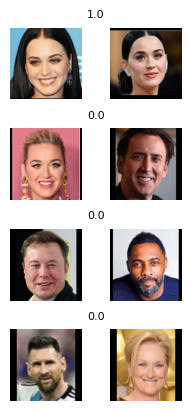

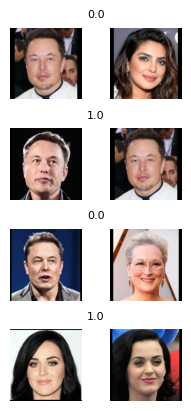

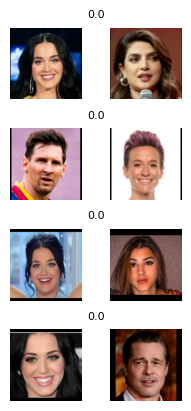

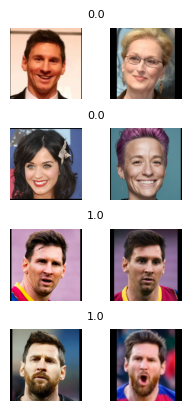

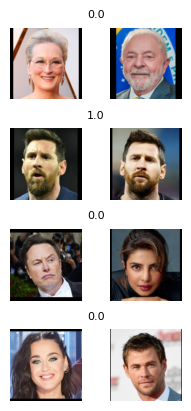

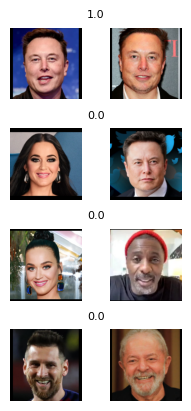

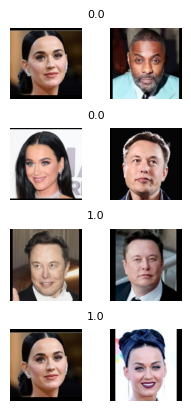

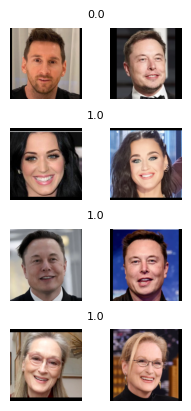

<Figure size 200x400 with 0 Axes>

In [27]:
visualize_dataset(train_ds, 4, TRAINING_BATCH_SIZE, 4)

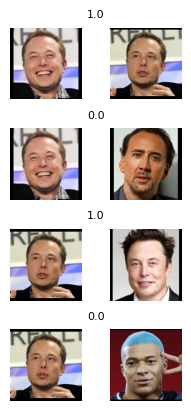

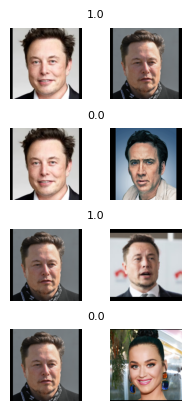

<Figure size 200x400 with 0 Axes>

In [28]:
visualize_dataset(validation_ds, 4, VALIDATION_BATCH_SIZE, 4)

# Defining the model

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

In [31]:
INPUT_SHAPE = (INPUT_SIZE, INPUT_SIZE, 3)

def initialize_base_network():

    inputs = tf.keras.layers.Input(INPUT_SHAPE)
    base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
    
    base_model.trainable = True
    fine_tune_at = len(base_model.layers)-int(len(base_model.layers)*.10)
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable =  False
          
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs=tf.keras.layers.Dense(64)(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [32]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [33]:
def buid_model():
    
    base_network = initialize_base_network()

    input_a = Input(shape=INPUT_SHAPE, name="left_input")
    vect_output_a = base_network(input_a)

    input_b = Input(shape=INPUT_SHAPE, name="right_input")
    vect_output_b = base_network(input_b)

    output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

    return Model([input_a, input_b], output)

In [34]:
model = buid_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input (InputLayer)       [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 64)           21933920    ['left_input[0][0]',             
                                                                  'right_input[0][0]']      

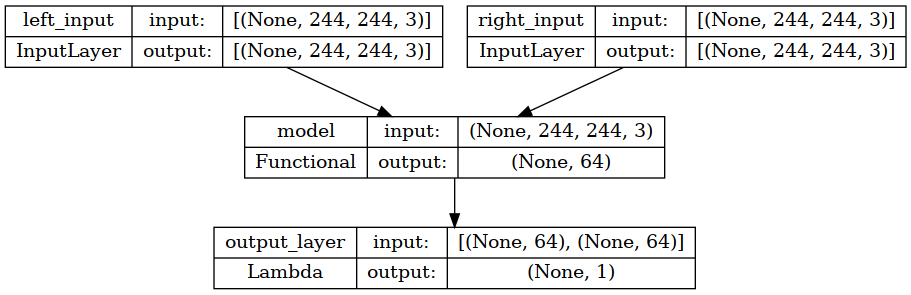

In [35]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

# Training

In [36]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [37]:
class Precision(tf.keras.metrics.Metric):

  def __init__(self, name='precision', **kwargs):
    super(Precision, self).__init__(name=name, **kwargs)
    self.true_positives = self.add_weight(name='tp', initializer='zeros')
    self.false_positives = self.add_weight(name='fp', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.math.less(y_pred, 0.5) 

    true_positives_values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    true_positives_values = tf.cast(true_positives_values, self.dtype)

    false_positives_values = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
    false_positives_values = tf.cast(false_positives_values, self.dtype)

    if sample_weight is not None:
      true_positives_sample_weight = tf.cast(sample_weight, self.dtype)
      true_positives_sample_weight = tf.broadcast_to(true_positives_sample_weight, true_positives_values.shape)
      true_positives_values = tf.multiply(true_positives_values, true_positives_sample_weight)

      false_positives_sample_weight = tf.cast(sample_weight, self.dtype)
      false_positives_sample_weight = tf.broadcast_to(false_positives_sample_weight, false_positives_values.shape)
      false_positives_values = tf.multiply(false_positives_values, false_positives_sample_weight)

    self.true_positives.assign_add(tf.reduce_sum(true_positives_values))
    self.false_positives.assign_add(tf.reduce_sum(false_positives_values))

  def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)

  def result(self):
    result = self.true_positives / (self.true_positives + self.false_positives)
    return result

class Recall(tf.keras.metrics.Metric):

  def __init__(self, name='recall', **kwargs):
    super(Recall, self).__init__(name=name, **kwargs)
    self.true_positives = self.add_weight(name='tp', initializer='zeros')
    self.false_negatives = self.add_weight(name='fn', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.math.less(y_pred, 0.5) 

    true_positives_values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    true_positives_values = tf.cast(true_positives_values, self.dtype)

    false_negatives_values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))
    false_negatives_values = tf.cast(false_negatives_values, self.dtype)

    if sample_weight is not None:
      true_positives_sample_weight = tf.cast(sample_weight, self.dtype)
      true_positives_sample_weight = tf.broadcast_to(true_positives_sample_weight, true_positives_values.shape)
      true_positives_values = tf.multiply(true_positives_values, true_positives_sample_weight)

      false_negatives_sample_weight = tf.cast(sample_weight, self.dtype)
      false_negatives_sample_weight = tf.broadcast_to(false_negatives_sample_weight, false_negatives_values.shape)
      false_negatives_values = tf.multiply(false_negatives_values, false_negatives_sample_weight)

    self.true_positives.assign_add(tf.reduce_sum(true_positives_values))
    self.false_negatives.assign_add(tf.reduce_sum(false_negatives_values))

  def reset_state(self):
        self.true_positives.assign(0)
        self.false_negatives.assign(0)

  def result(self):
    result = self.true_positives / (self.true_positives + self.false_negatives)
    return result

In [39]:
EPOCHS = 20

model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=tf.keras.optimizers.RMSprop(),
              metrics=[Precision(), Recall()])

history = model.fit(train_ds, steps_per_epoch=(len(tr_pairs) // TRAINING_BATCH_SIZE),
                    validation_data=validation_ds,
                    epochs=EPOCHS)

Epoch 1/20
67/67 [==============================] - 28s 155ms/step - loss: 1.7379 - precision: 1.0000 - recall: 0.0037 - val_loss: 1.3555 - val_precision: nan - val_recall: 0.0000e+00
Epoch 2/20
67/67 [==============================] - 6s 86ms/step - loss: 0.3464 - precision: 0.7037 - recall: 0.0706 - val_loss: 0.3853 - val_precision: 1.0000 - val_recall: 0.0167
Epoch 3/20
67/67 [==============================] - 6s 86ms/step - loss: 0.2463 - precision: 0.7625 - recall: 0.2293 - val_loss: 0.1893 - val_precision: 0.8636 - val_recall: 0.3167
Epoch 4/20
67/67 [==============================] - 6s 86ms/step - loss: 0.1840 - precision: 0.8671 - recall: 0.5131 - val_loss: 0.1670 - val_precision: 0.9412 - val_recall: 0.5333
Epoch 5/20
67/67 [==============================] - 6s 86ms/step - loss: 0.1534 - precision: 0.9010 - recall: 0.6816 - val_loss: 0.1634 - val_precision: 0.7708 - val_recall: 0.6167
Epoch 6/20
67/67 [==============================] - 6s 86ms/step - loss: 0.1154 - precision:

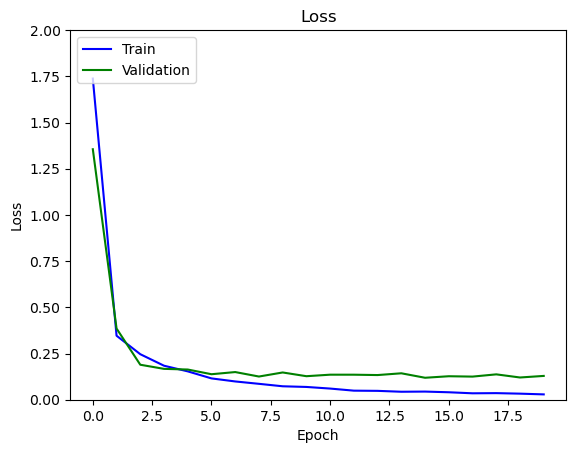

In [41]:
plt.title('Loss')
plt.ylim(0, 2.)
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='green', label='val_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [42]:
def compute_performance(y_true, y_pred):

    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for actual, distance in zip(y_true, y_pred):
        if actual > 0 and distance < .5:
            TP += 1
        elif actual > 0 and distance >= .5:
            FN += 1
        elif actual < 1 and distance < .5:
            FP += 1
        elif actual < 1 and distance >= .5:
            TN += 1

    precision = float('nan')
    recall = float('nan')
    if (TP + FP) > 0 :
        precision = TP / (TP + FP)
    if (TP + FN) > 0 :
        recall = TP / (TP + FN)

    return precision, recall, TP, TN, FP, FN

In [44]:

import numpy as np

loss = model.evaluate(validation_ds)

y_pred_test = model.predict(validation_ds)

test_y = np.concatenate([y for x, y in validation_ds], axis=0)
test_precision, test_recall, TP, TN, FP, FN = compute_performance(test_y, y_pred_test)

print("Test Loss = {}, Test Precision = {}, Test Recall = {}".format(loss, test_precision, test_recall))
print("TP = {}, TN = {}, FP = {}, FN = {}".format(TP, TN, FP, FN))

60/60 [==============================] - 3s 21ms/step
Test Loss = [0.12880998849868774, 0.8958333134651184, 0.7166666388511658], Test Precision = 0.8958333333333334, Test Recall = 0.7166666666666667
TP = 43, TN = 55, FP = 5, FN = 17


In [48]:
def visualize_test_pairs(rows_per_image = 10, test_instances = 10):

    fig = plt.figure(layout='constrained', figsize=(2*2, 2*rows_per_image))
    subfigs = fig.subfigures(rows_per_image, 1, wspace=0.07)
    subfigs = subfigs.flatten()
    row = 0
    for images, labels in validation_ds.take(test_instances):

        predictions = model.predict(images)
        for i in range(VALIDATION_BATCH_SIZE):

            axs = subfigs[row % rows_per_image].subplots(1, 2, sharey=True)

            img_A = (images[0][i].numpy()*255).astype("uint8")
            img_B = (images[1][i].numpy()*255).astype("uint8")
            label = labels[i].numpy()

            prediction = predictions[i][0]
        
            bgcolor = (1, 1, 1)
            if (label > 0 and prediction >= 0.5) or (label < 1 and prediction < 0.5):
                bgcolor = (1, 0, 0)

            axs[0].imshow(img_A)
            axs[0].axis("off")
            axs[1].imshow(img_B)
            axs[1].axis("off")
            title_fmt = "Distance is {distance:.4f} for {similarity} images"
            if label > 0:
                title = title_fmt.format(distance = prediction, similarity = "SIMILAR")
            else:
                title = title_fmt.format(distance = prediction, similarity = "different")

            subfigs[row % rows_per_image].suptitle(title, fontsize=8)
            row += 1
            if row % rows_per_image == 0:
                fig
                fig = plt.figure(layout='constrained', figsize=(2*2, 2*rows_per_image))
                subfigs = fig.subfigures(rows_per_image, 1, wspace=0.07)
                subfigs = subfigs.flatten()

1/1 [==============================] - 0s 19ms/step


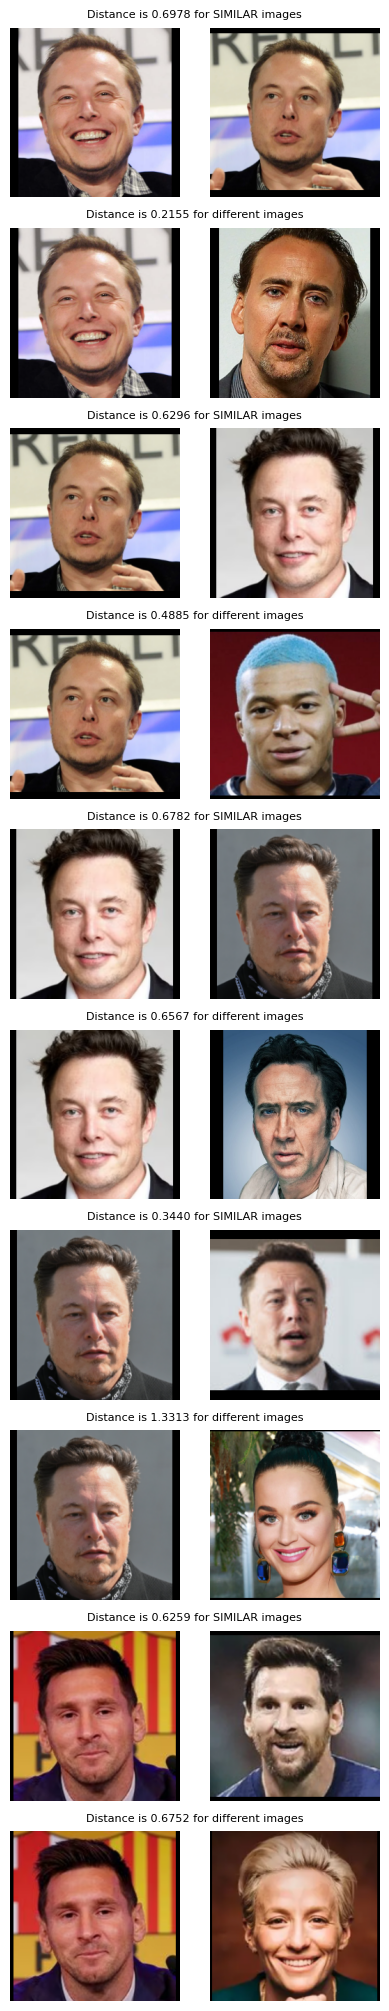

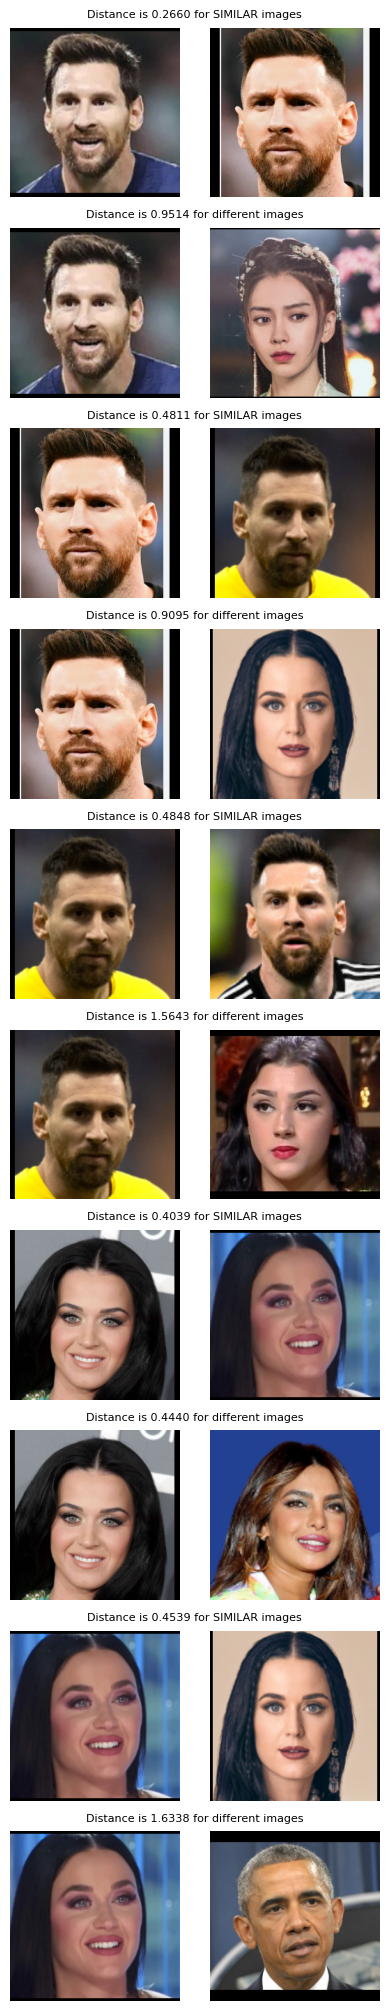

<Figure size 400x2000 with 0 Axes>

In [49]:
visualize_test_pairs()